### 專案名稱: 第四屆機器學習百日馬拉松
### 功能描述: 第51~53天作業(期中考)
### 版權所有: Dunk  
### 程式撰寫: Dunk  
### 撰寫日期：2020/04/27
### 改版日期:  
### 改版備註: 
### 2020/04/29 增加梯度提升機及隨機森林
### 2020/04/30 增加資料清洗與評估結果顯示
### 2020/05/04 增加資料清洗

請至以下Kaggle競賽平台期中考連結參加考試，請按join competition加入測驗 

並將任一次提交完成畫面截圖，上傳到github並回到官網完成提交。(提交畫面截圖範例)

https://www.kaggle.com/t/4e455552ac9b4a088ccae16e27d22be8

### ANS:

#### 前處理 Processing步驟
1. 資料讀取
2. 格式調整
3. 填補缺值
4. 去離群值
5. 特徵縮放

####  1. 資料讀取
#### 匯入所需套件

In [32]:
# 做完特徵工程前的所有準備 (與前範例相同)
import os
import pandas as pd
import numpy as np
import copy, time
import pprint
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

data_path = 'data/'
df_train = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')
index_name = 'name'
df_train = df_train.set_index(df_train[index_name])
df_test = df_test.set_index(df_test[index_name])
print(df_train.shape)
print(df_test.shape)

(113, 22)
(33, 21)


####  2. 格式調整

In [33]:
# 重組資料成為訓練 / 預測用格式
target_col = 'poi'
key_col = 'name'
df_train[target_col] = df_train[target_col].map(lambda i: 1 if i == True else 0)
train_Y = df_train[target_col]
ids = df_test[key_col]
df_train_nokey = df_train.drop([key_col] , axis=1)
df_test_nokey = df_test.drop([key_col] , axis=1)
df = pd.concat([df_train_nokey,df_test_nokey])

In [34]:
# 秀出資料欄位的類型與數量
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df = dtype_df.groupby("Column Type").aggregate('count').reset_index()
dtype_df

,Column Type,Count
0,float64,20
1,object,1


In [35]:
#確定只有 int64, float64, object 三種類型後, 分別將欄位名稱存於二個 list(數值及文字) 中
num_features = []
object_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)    
    else:
        object_features.append(feature)
print(f'{len(num_features)} num Features : {num_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

20 num Features : ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'poi', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']

1 Object Features : ['email_address']


'column[bonus]s value is from 97343619.0 to 70000.0'


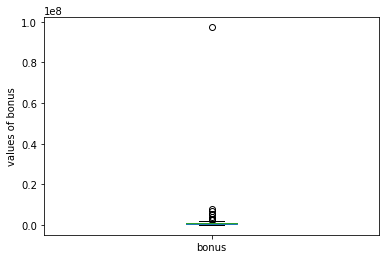

'column[deferral_payments]s value is from 32083396.0 to -102500.0'


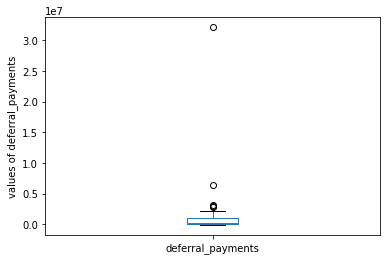

'column[deferred_income]s value is from -833.0 to -27992891.0'


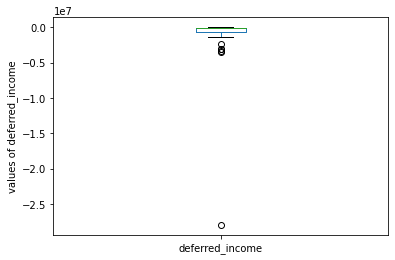

'column[director_fees]s value is from 1398517.0 to 3285.0'


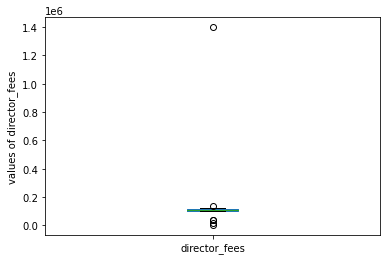

'column[exercised_stock_options]s value is from 311764000.0 to 3285.0'


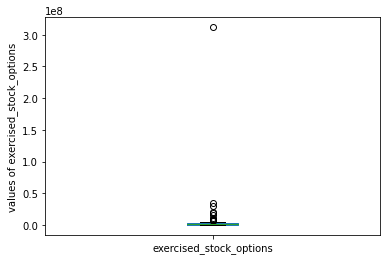

'column[expenses]s value is from 5235198.0 to 148.0'


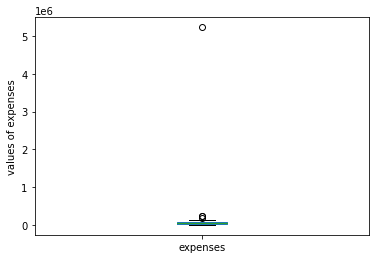

'column[from_messages]s value is from 14368.0 to 12.0'


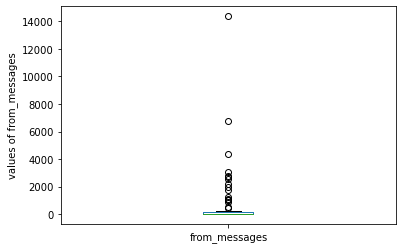

'column[from_poi_to_this_person]s value is from 528.0 to 0.0'


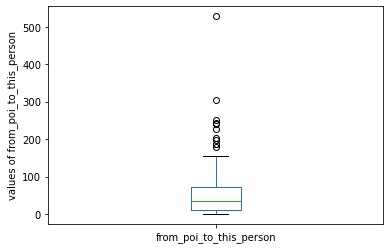

'column[from_this_person_to_poi]s value is from 609.0 to 0.0'


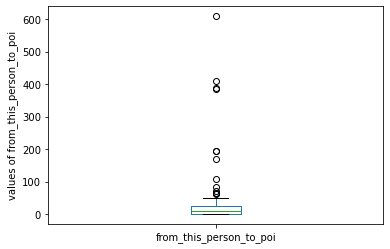

'column[loan_advances]s value is from 83925000.0 to 400000.0'


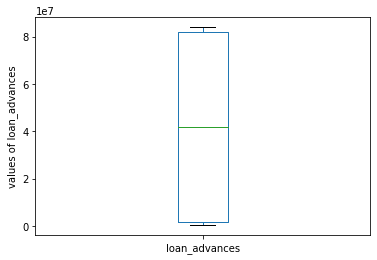

'column[long_term_incentive]s value is from 48521928.0 to 69223.0'


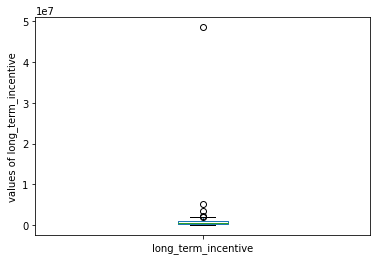

'column[other]s value is from 42667589.0 to 2.0'


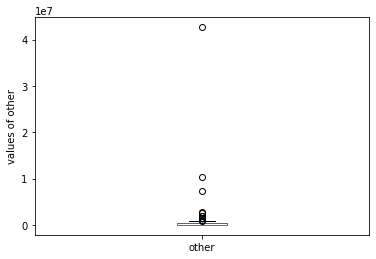

'column[poi]s value is from 1.0 to 0.0'


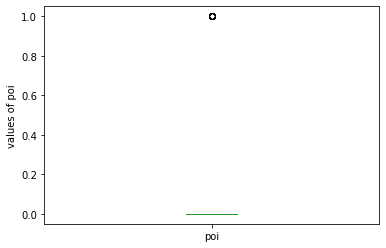

'column[restricted_stock]s value is from 130322299.0 to -2604490.0'


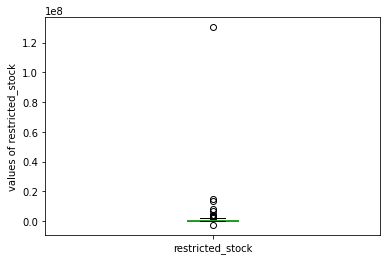

'column[restricted_stock_deferred]s value is from 15456290.0 to -7576788.0'


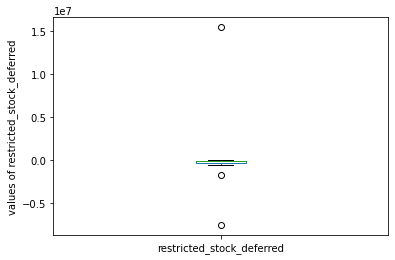

'column[salary]s value is from 26704229.0 to 477.0'


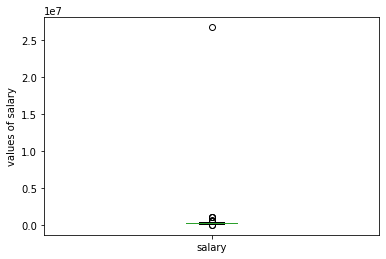

'column[shared_receipt_with_poi]s value is from 5521.0 to 2.0'


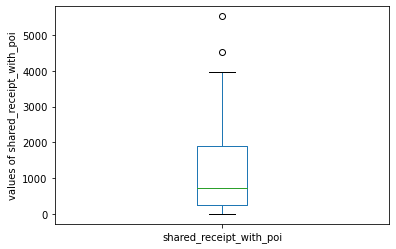

'column[to_messages]s value is from 15149.0 to 57.0'


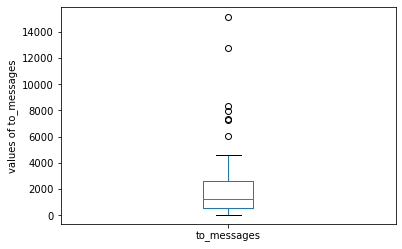

'column[total_payments]s value is from 309886585.0 to 148.0'


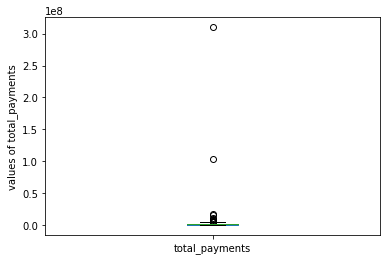

'column[total_stock_value]s value is from 434509511.0 to -44093.0'


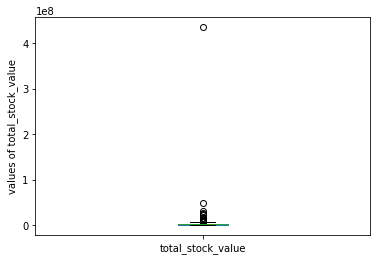

In [36]:
# 繪製廂型圖
import matplotlib.pyplot as plt
%matplotlib inline

# 檢視數值欄位的數值範圍
# 參考網址
# https://www.itread01.com/content/1541665023.html
for col in num_features:    
    pprint.pprint('column[{0}]''s value is from {1} to {2}'.format(col,df[col].max(),df[col].min()))
    
    fig,axes = plt.subplots()
    df[col].plot(kind='box',ax=axes)
    axes.set_ylabel('values of {0}'.format(col))
    plt.show()

In [37]:
# 欄位值計算
print(df.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).sort_values())
print('----------------------')
print(df.select_dtypes(include=["float64"]).apply(pd.Series.nunique, axis = 0).sort_values())
print(df['poi'])

email_address    111
dtype: int64
----------------------
poi                            2
loan_advances                  4
director_fees                 17
restricted_stock_deferred     18
deferral_payments             39
from_this_person_to_poi       41
bonus                         41
deferred_income               44
long_term_incentive           52
from_poi_to_this_person       57
from_messages                 64
shared_receipt_with_poi       83
to_messages                   86
other                         92
expenses                      94
salary                        94
restricted_stock              97
exercised_stock_options      101
total_stock_value            124
total_payments               125
dtype: int64
name
RICE KENNETH D          1.0
SKILLING JEFFREY K      1.0
SHELBY REX              1.0
KOPPER MICHAEL J        1.0
CALGER CHRISTOPHER F    1.0
                       ... 
BIBI PHILIPPE A         NaN
SHERRIFF JOHN R         NaN
GIBBS DANA R            NaN
LINDHOLM TOD 

In [38]:
# 削減類別欄位, 只剩數值型欄位
df_num_only = df[num_features]
train_num = train_Y.shape[0]
df_num_only.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
name,,,,,,,,,,,,,,,,,,,,
RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,1.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,1.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
SHELBY REX,200000.0,NaN,-4167.0,NaN,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,1.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,1.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,1.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [39]:
# 欄位值計算
print(df_num_only.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).sort_values())
print('----------------------')
print(df_num_only.select_dtypes(include=["float64"]).apply(pd.Series.nunique, axis = 0).sort_values())

Series([], dtype: float64)
----------------------
poi                            2
loan_advances                  4
director_fees                 17
restricted_stock_deferred     18
deferral_payments             39
from_this_person_to_poi       41
bonus                         41
deferred_income               44
long_term_incentive           52
from_poi_to_this_person       57
from_messages                 64
shared_receipt_with_poi       83
to_messages                   86
other                         92
expenses                      94
salary                        94
restricted_stock              97
exercised_stock_options      101
total_stock_value            124
total_payments               125
dtype: int64


In [40]:
# 空值補 -1, 做羅吉斯迴歸
import pprint
df_m1 = df_num_only.fillna(-1)
train_X = df_m1[:train_num]
estimator = LogisticRegression()
pprint.pprint(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

# 空值補上平均值
df_m2 = df_num_only.fillna(df_num_only.mean())
train_X = df_m2[:train_num]
estimator = LogisticRegression()
pprint.pprint(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

# 空值補上中位值
df_m3 = df_num_only.fillna(df_num_only.median())
train_X = df_m3[:train_num]
estimator = LogisticRegression()
pprint.pprint(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

# 空值補上0
df_m4 = df_num_only.fillna(0)
train_X = df_m4[:train_num]
estimator = LogisticRegression()
pprint.pprint(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

0.7521739130434784
0.9023715415019762
0.8494071146245059
0.7968379446640317


#### 由上面計算結果，補上平均值的效果最好

In [41]:
# 空值補平均值, 搭配最小最大化
df_1 = df_num_only.fillna(df_num_only.mean())
df_temp = MinMaxScaler().fit_transform(df_1)
train_X = df_temp[:train_num]
estimator = LogisticRegression()
pprint.pprint(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

1.0


In [42]:
# 空值補平均值, 搭配標準化
df_1 = df_num_only.fillna(df_num_only.mean())
df_temp = StandardScaler().fit_transform(df_1)
train_X = df_temp[:train_num]
estimator = LogisticRegression()
pprint.pprint(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

1.0


#### 3.填補缺值

In [43]:
#檢查統計值
df.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,8.200000e+01,3.900000e+01,4.900000e+01,1.700000e+01,1.020000e+02,9.500000e+01,86.000000,86.000000,86.000000,4.000000e+00,6.600000e+01,9.300000e+01,113.000000,1.100000e+02,1.800000e+01,9.500000e+01,86.000000,86.000000,1.250000e+02,1.260000e+02
mean,2.374235e+06,1.642674e+06,-1.140475e+06,1.668049e+05,5.987054e+06,1.087289e+05,608.790698,64.895349,41.232558,4.196250e+07,1.470361e+06,9.190650e+05,0.115044,2.321741e+06,1.664106e+05,5.621943e+05,1176.465116,2073.860465,5.081526e+06,6.773957e+06
std,1.071333e+07,5.161930e+06,4.025406e+06,3.198914e+05,3.106201e+07,5.335348e+05,1841.033949,86.979244,100.073111,4.708321e+07,5.942759e+06,4.589253e+06,0.320497,1.251828e+07,4.201494e+06,2.716369e+06,1178.317641,2582.700981,2.906172e+07,3.895777e+07
min,7.000000e+04,-1.025000e+05,-2.799289e+07,3.285000e+03,3.285000e+03,1.480000e+02,12.000000,0.000000,0.000000,4.000000e+05,6.922300e+04,2.000000e+00,0.000000,-2.604490e+06,-7.576788e+06,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,4.312500e+05,8.157300e+04,-6.948620e+05,9.878400e+04,5.278862e+05,2.261400e+04,22.750000,10.000000,1.000000,1.600000e+06,2.812500e+05,1.215000e+03,0.000000,2.540180e+05,-3.896218e+05,2.118160e+05,249.750000,541.250000,3.944750e+05,4.945102e+05
50%,7.693750e+05,2.274490e+05,-1.597920e+05,1.085790e+05,1.310814e+06,4.695000e+04,41.000000,35.000000,8.000000,4.176250e+07,4.420350e+05,5.238200e+04,0.000000,4.517400e+05,-1.469750e+05,2.599960e+05,740.500000,1211.000000,1.101393e+06,1.102872e+06
75%,1.200000e+06,1.002672e+06,-3.834600e+04,1.137840e+05,2.547724e+06,7.995250e+04,145.500000,72.250000,24.750000,8.212500e+07,9.386720e+05,3.620960e+05,0.000000,1.002370e+06,-7.500975e+04,3.121170e+05,1888.250000,2634.750000,2.093263e+06,2.949847e+06
max,9.734362e+07,3.208340e+07,-8.330000e+02,1.398517e+06,3.117640e+08,5.235198e+06,14368.000000,528.000000,609.000000,8.392500e+07,4.852193e+07,4.266759e+07,1.000000,1.303223e+08,1.545629e+07,2.670423e+07,5521.000000,15149.000000,3.098866e+08,4.345095e+08


In [44]:
# TOTAL 及 THE TRAVEL AGENCY IN THE PARK 是合計欄(非個人資料)，要刪除
#驗證資料內容前先複製一份
dt_eval = df.copy()
print(dt_eval.shape[0])
print('index[total]:{0}'.format(str(len(dt_eval[dt_eval.index == 'TOTAL']))))
print('index[THE TRAVEL AGENCY IN THE PARK]:{0}'.format(str(len(dt_eval[dt_eval.index\
== 'THE TRAVEL AGENCY IN THE PARK']))))

dt_eval = dt_eval.drop(dt_eval.loc[dt_eval.index=='TOTAL'].index)
dt_eval = dt_eval.drop(dt_eval.loc[dt_eval.index=='THE TRAVEL AGENCY IN THE PARK'].index)
print(dt_eval.shape[0])

146
index[total]:1
index[THE TRAVEL AGENCY IN THE PARK]:1
144


In [45]:
# 計算付款資料合理性
payment_data = ['salary','bonus','long_term_incentive','deferred_income','deferral_payments','loan_advances','other'\
               ,'expenses','director_fees','total_payments']
errors = (dt_eval[dt_eval[payment_data[:-1]].sum(axis='columns') !=dt_eval['total_payments']])
print(errors.shape)
dt_eval[payment_data] = dt_eval[payment_data].fillna(0)
errors = (dt_eval[dt_eval[payment_data[:-1]].sum(axis='columns') !=dt_eval['total_payments']])
# 補零後，還是有兩筆資料有問題
print(errors.shape)
errors

(23, 21)
(2, 21)


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
name,,,,,,,,,,,,,,,,,,,,,
BELFER ROBERT,0.0,-102500.0,0.0,3285.0,NaN,3285.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,44093.0,0.0,NaN,NaN,102500.0,-44093.0
BHATNAGAR SANJAY,0.0,0.0,0.0,137864.0,sanjay.bhatnagar@enron.com,2604490.0,0.0,29.0,0.0,1.0,...,0.0,137864.0,NaN,-2604490.0,15456290.0,0.0,463.0,523.0,15456290.0,NaN


In [46]:
# 計算股票資產資料合理性
stock_data = ['exercised_stock_options','restricted_stock','restricted_stock_deferred',\
             'total_stock_value']
errors = (dt_eval[dt_eval[stock_data[:-1]].sum(axis='columns') !=dt_eval['total_stock_value']])
print(errors.shape)
dt_eval[stock_data] = dt_eval[stock_data].fillna(0)
errors = (dt_eval[dt_eval[stock_data[:-1]].sum(axis='columns') !=dt_eval['total_stock_value']])
# 補零後，還是有兩筆資料有問題
print(errors.shape)
errors

(20, 21)
(2, 21)


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
name,,,,,,,,,,,,,,,,,,,,,
BELFER ROBERT,0.0,-102500.0,0.0,3285.0,NaN,3285.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,44093.0,0.0,NaN,NaN,102500.0,-44093.0
BHATNAGAR SANJAY,0.0,0.0,0.0,137864.0,sanjay.bhatnagar@enron.com,2604490.0,0.0,29.0,0.0,1.0,...,0.0,137864.0,NaN,-2604490.0,15456290.0,0.0,463.0,523.0,15456290.0,0.0


In [47]:
# 查看有問題的兩筆資料，發現資料位移
#驗證資料內容前先複製一份
dt_eval = df.copy()
dt_eval[payment_data] = dt_eval[payment_data].fillna(0)
dt_eval[stock_data] = dt_eval[stock_data].fillna(0)

# Check for any more errors with the payment data
print(len(dt_eval[dt_eval[payment_data[:-1]].sum(axis='columns') !=dt_eval['total_payments']]))
# Check for any errors with the stock data
print(len(dt_eval[dt_eval[stock_data[:-1]].sum(axis='columns') !=dt_eval['total_stock_value']]))

# 'BELFER ROBERT' 資料發現左移,向右SHIFT
key_name = 'BELFER ROBERT'
payment_len = dt_eval[payment_data[:-1]].shape[1]
stock_len = dt_eval[stock_data[:-1]].shape[1]

for i in range(payment_len):
    dt_eval.loc[key_name,payment_data[i]] = dt_eval.loc[key_name,payment_data[i+1]]
dt_eval.loc[key_name,payment_data[payment_len]] = dt_eval.loc[key_name,stock_data[0]]

for i in range(stock_len):
    dt_eval.loc[key_name,stock_data[i]] = float(dt_eval.loc[key_name,stock_data[i+1]])
dt_eval.loc[key_name,stock_data[stock_len]] = 0


# 'BELFER ROBERT' 資料發現右移,向左SHIFT
key_name = 'BHATNAGAR SANJAY'

for i in np.arange(1,stock_len+1)[::-1]:
    dt_eval.loc[key_name,stock_data[i]] = float(dt_eval.loc[key_name,stock_data[i-1]])
dt_eval.loc[key_name,stock_data[0]] = dt_eval.loc[key_name,payment_data[payment_len]]

for i in np.arange(1,payment_len+1)[::-1]:
    dt_eval.loc[key_name,payment_data[i]] = dt_eval.loc[key_name,payment_data[i-1]]
dt_eval.loc[key_name,payment_data[0]] = 0

# Check for any more errors with the payment data
print(len(dt_eval[dt_eval[payment_data[:-1]].sum(axis='columns') !=dt_eval['total_payments']]))
# Check for any errors with the stock data
print(len(dt_eval[dt_eval[stock_data[:-1]].sum(axis='columns') !=dt_eval['total_stock_value']]))

2
2
0
0


In [48]:
# 檢查次數項目是否為正整數(大於等於0)
email_data=['from_this_person_to_poi','from_poi_to_this_person','to_messages',\
            'shared_receipt_with_poi','to_messages','from_messages']
for col_name in email_data:    
    if all(dt_eval[col_name].dropna().unique()>=0):
        print('column [{0}] pass!'.format(col_name))        
    else:
        print('column [{0}] fail!'.format(col_name))
        print(dt_eval[col_name].dropna().unique())

column [from_this_person_to_poi] pass!
column [from_poi_to_this_person] pass!
column [to_messages] pass!
column [shared_receipt_with_poi] pass!
column [to_messages] pass!
column [from_messages] pass!


#### 4.去離群值

In [49]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data)

In [50]:
#顯示訓練集其中資料遺失比例
na_check(dt_eval)

,Missing Ratio
to_messages,41.095890
shared_receipt_with_poi,41.095890
from_this_person_to_poi,41.095890
from_poi_to_this_person,41.095890
from_messages,41.095890
email_address,23.972603
poi,22.602740


In [52]:
# 針對email次數設定,用平均值補齊
# Fill in the NaN email data with the mean of column grouped by poi/
# non_poi
from sklearn.impute import SimpleImputer
# 填補器 : 設定缺失值補平均值
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# dt_eval_meet = dt_eval.drop(dt_eval.loc[dt_eval.index=='TOTAL'].index)
# dt_eval_meet = dt_eval_meet.drop(dt_eval_meet.loc[dt_eval_meet.index\
#                                                   =='THE TRAVEL AGENCY IN THE PARK'].index)
# df_poi = dt_eval_meet[dt_eval_meet['poi'] == True]
# df_nonpoi = dt_eval_meet[dt_eval_meet['poi']==False]
# df_nan = dt_eval_meet[pd.isna(dt_eval_meet['poi'])]
# df_poi.loc[:, email_data] = imputer.fit_transform(df_poi.loc[:,email_data]);
# df_nonpoi.loc[:, email_data] = imputer.fit_transform(df_nonpoi.loc[:,email_data]);
# df_nan.loc[:, email_data] = imputer.fit_transform(df_nan.loc[:,email_data]);
# dt_eval = df_poi.append(df_nonpoi)
# dt_eval = dt_eval.append(df_nan)
print(dt_eval.loc['THE TRAVEL AGENCY IN THE PARK'])

bonus                             0
deferral_payments                 0
deferred_income                   0
director_fees                     0
email_address                   NaN
exercised_stock_options           0
expenses                          0
from_messages                   NaN
from_poi_to_this_person         NaN
from_this_person_to_poi         NaN
loan_advances                     0
long_term_incentive               0
other                        362096
poi                               0
restricted_stock                  0
restricted_stock_deferred         0
salary                            0
shared_receipt_with_poi         NaN
to_messages                     NaN
total_payments               362096
total_stock_value                 0
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object


In [22]:
#顯示訓練集其中資料遺失比例(只剩poi跟email_address)
na_check(dt_eval)

,Missing Ratio
email_address,22.916667
poi,22.222222


In [23]:
IQR = dt_eval.quantile(q=0.75) - dt_eval.quantile(q=0.25)
first_quartile = dt_eval.quantile(q=0.25)
third_quartile = dt_eval.quantile(q=0.75)
outliers = dt_eval[(dt_eval>(third_quartile + 1.5*IQR) ) | (dt_eval<(first_quartile
- 1.5*IQR) )].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)
outliers.head(12)

name
LAY KENNETH L         13
FREVERT MARK A        12
SKILLING JEFFREY K     8
BAXTER JOHN C          8
BELDEN TIMOTHY N       8
LAVORATO JOHN J        8
KEAN STEVEN J          7
WHALLEY LAWRENCE G     7
RICE KENNETH D         6
KITCHEN LOUISE         5
HAEDICKE MARK E        5
BECK SALLY W           5
dtype: int64

In [24]:
# dt_eval['poi'].value_counts()
# # Remove the outlier individuals
# dt_eval.drop(axis=0, labels=['FREVERT MARK A', 'LAVORATO JOHN J',
# 'WHALLEY LAWRENCE G', 'BAXTER JOHN C'], inplace=True)
# # Find the number of poi and non poi now in the data
# dt_eval['poi'].value_counts()

### 特徵工程

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
# 特徵欄位清單(只取數值欄位)
target_col = 'poi'
key_col = 'name'

# 切分訓練集與測試集

df_train_pre = dt_eval[pd.isna(dt_eval[target_col])==False].copy()
df_train_pre = df_train_pre.drop(df_train_pre.loc[df_train_pre.index=='TOTAL'].index)
df_train_pre = df_train_pre.drop(df_train_pre.loc[df_train_pre.index=='THE TRAVEL AGENCY IN THE PARK'].index)
labels=['FREVERT MARK A', 'LAVORATO JOHN J','WHALLEY LAWRENCE G', 'BAXTER JOHN C']
for lab in labels:
    df_train_pre = df_train_pre.drop(df_train_pre.loc[df_train_pre.index==lab].index)

train_Y = df_train_pre[target_col]
df_train_pre = df_train_pre[num_features]
df_train_pre = df_train_pre.drop([target_col] , axis=1)
                               
df_test_pre = dt_eval[pd.isna(dt_eval[target_col])==True].copy()
df_test_pre = df_test_pre[num_features]
df_test_pre = df_test_pre.drop([target_col] , axis=1)
ids = df_test[key_col]


# 縮放器 : 設定特徵縮放到 0~1 區間
scaler = MinMaxScaler(feature_range = (0, 1))

# 縮放器載入, 對 train, test 進行縮放轉換
df_train_pre = scaler.fit_transform(df_train_pre)
df_test_pre = scaler.fit_transform(df_test_pre)

# 切分訓練集與測試集
train_X = df_train_pre
test_X = df_test_pre

print('Training data shape: ', train_X.shape)
print('Testing data shape: ', test_X.shape)

Training data shape:  (109, 19)
Testing data shape:  (32, 19)


#### Fit the model (1) 羅吉斯迴歸

##### 驗證訓練集
[Pandas: Appending a row to a dataframe and specify its index label](https://stackoverflow.com/questions/16824607/pandas-appending-a-row-to-a-dataframe-and-specify-its-index-label "Pandas: Appending a row to a dataframe and specify its index label")

In [26]:
df_eval_result = pd.DataFrame(columns=['accuracy_score','f1_score','precision_score','recall_score'])
def show_eval_result(y_test,y_pred , model_name):
    # 分類要驗證正確率(accucry)
    acc = accuracy_score(y_test,y_pred)
    print("accuracy_score: ", acc)
    f1 = f1_score(y_test,y_pred)
    print("f1_score: ", f1)
    # 使用 Precision 評估
    precision = precision_score(y_test,y_pred)
    print("precision_score: ", precision)
    # 使用 recall 評估
    recall  = recall_score(y_test,y_pred)
    print("recall_score: ", recall)
    row = pd.Series({'accuracy_score':acc,'f1_score':f1,'precision_score':precision,'recall_score':recall},name=model_name)
    return row

In [27]:
# 切分訓練集與測試集
x_train,x_test,y_train,y_test = train_test_split(train_X,train_Y,test_size=0.25,random_state=4)

# 使用羅吉斯迴歸
lr =  LogisticRegression(C = 0.0001)

# 進行訓練
lr.fit(x_train,y_train)

# 預測測試集
y_pred = lr.predict(x_test)

# 分類要驗證正確率(accucry)
df_eval_result = df_eval_result.append(show_eval_result(y_test,y_pred,'lr'))

accuracy_score:  0.8928571428571429
f1_score:  0.0
precision_score:  0.0
recall_score:  0.0


In [28]:
# 設定模型與模型參數
lr = LogisticRegression(C = 0.0001)
lr.fit(train_X, train_Y)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
# 儲存預測結果(羅吉斯迴歸)
output_path = 'output/'
lr_pred = lr.predict_proba(test_X)[:, 1]
submit = pd.DataFrame({'name': ids, 'poi': lr_pred})
f_app_result = os.path.join(output_path, 'Day_051_To_053_lr.csv')
submit.to_csv(f_app_result,index=False)

ValueError: array length 32 does not match index length 33

#### Fit the model (2) 梯度提升機

##### 驗證訓練集

In [ ]:
# 切分訓練集與測試集
x_train,x_test,y_train,y_test = train_test_split(train_X,train_Y,test_size=0.25,random_state=4)

# 使用梯度提升機
gdbt =  GradientBoostingClassifier()

# 進行訓練
gdbt.fit(x_train,y_train)

# 預測測試集
y_pred = gdbt.predict(x_test)

# 分類要驗證正確率(accucry)
df_eval_result = df_eval_result.append(show_eval_result(y_test,y_pred,'gdbt'))

In [ ]:
# 設定模型與模型參數
gdbt =  GradientBoostingClassifier()
gdbt.fit(train_X, train_Y)

In [ ]:
# 儲存預測結果(梯度提升機預測檔 )
output_path = 'output/'
gdbt_pred = gdbt.predict_proba(test_X)[:, 1]
submit = pd.DataFrame({'name': ids, 'poi': gdbt_pred})
f_app_result = os.path.join(output_path, 'Day_051_To_053_gdbt.csv')
submit.to_csv(f_app_result,index=False)

#### Fit the model (3) 隨機森林

##### 驗證訓練集

In [ ]:
# 切分訓練集與測試集
x_train,x_test,y_train,y_test = train_test_split(train_X,train_Y,test_size=0.25,random_state=4)

# 使用隨機森林
rf =  RandomForestClassifier()

# 進行訓練
rf.fit(x_train,y_train)

# 預測測試集
y_pred = rf.predict(x_test)

# 分類要驗證正確率(accucry)
df_eval_result = df_eval_result.append(show_eval_result(y_test,y_pred,'rf'))

In [ ]:
# 設定模型與模型參數
rf =  RandomForestClassifier()
rf.fit(train_X, train_Y)

In [ ]:
# 儲存預測結果(隨機森林預測檔 )
output_path = 'output/'
rf_pred = rf.predict_proba(test_X)[:, 1]
submit = pd.DataFrame({'name': ids, 'poi': rf_pred})
f_app_result = os.path.join(output_path, 'Day_051_To_053_rf.csv')
submit.to_csv(f_app_result,index=False)

#### Fit the model (4) 堆疊泛化 ( Stacking)

##### 驗證訓練集

In [ ]:
from mlxtend.classifier import StackingClassifier
# 切分訓練集與測試集
x_train,x_test,y_train,y_test = train_test_split(train_X,train_Y,test_size=0.25,random_state=4)

# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林
lr =  LogisticRegression()
gdbt =  GradientBoostingClassifier()
rf =  RandomForestClassifier()
# 進行訓練
lr.fit(x_train,y_train)
gdbt.fit(x_train,y_train)
rf.fit(x_train,y_train)

# stacking
meta_estimator = GradientBoostingClassifier(tol=100, subsample=0.70, n_estimators=50, 
                                           max_features='sqrt', max_depth=4, learning_rate=0.3)

stacking = StackingClassifier(classifiers = [lr, gdbt, rf], meta_classifier=meta_estimator,\
                              use_probas=True, average_probas=False)

stacking.fit(x_train,y_train)
# 預測測試集
y_pred = stacking.predict(x_test)

# 分類要驗證正確率(accucry)
df_eval_result = df_eval_result.append(show_eval_result(y_test,y_pred,'stacking'))

In [ ]:
# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林
lr =  LogisticRegression()
gdbt =  GradientBoostingClassifier()
rf =  RandomForestClassifier()
# 進行訓練
lr.fit(train_X, train_Y)
gdbt.fit(train_X, train_Y)
rf.fit(train_X, train_Y)

# stacking
meta_estimator = GradientBoostingClassifier(tol=100, subsample=0.70, n_estimators=50, 
                                           max_features='sqrt', max_depth=4, learning_rate=0.3)

stacking = StackingClassifier(classifiers = [lr, gdbt, rf], meta_classifier=meta_estimator,\
                              use_probas=True, average_probas=False)

stacking.fit(train_X, train_Y)

In [ ]:
# 儲存預測結果(堆疊泛化 )
output_path = 'output/'
stacking_pred = stacking.predict_proba(test_X)[:, 1]
submit = pd.DataFrame({'name': ids, 'poi': stacking_pred})
f_app_result = os.path.join(output_path, 'Day_051_To_053_stacking.csv')
submit.to_csv(f_app_result,index=False)

#### Fit the model (5) AdaBoostClassifier

##### 驗證訓練集

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# 切分訓練集與測試集
x_train,x_test,y_train,y_test = train_test_split(train_X,train_Y,test_size=0.25,random_state=4)

# 使用隨機森林
abc =  AdaBoostClassifier(n_estimators=100)

# 進行訓練
abc.fit(x_train,y_train)

# 預測測試集
y_pred = abc.predict(x_test)

# 分類要驗證正確率(accucry)
df_eval_result = df_eval_result.append(show_eval_result(y_test,y_pred,'abc'))

In [ ]:
# 設定模型與模型參數
abc =  AdaBoostClassifier(n_estimators=100)
abc.fit(train_X, train_Y)

In [ ]:
# 儲存預測結果(隨機森林預測檔 )
output_path = 'output/'
abc_pred = abc.predict_proba(test_X)[:, 1]
submit = pd.DataFrame({'name': ids, 'poi': rf_pred})
f_app_result = os.path.join(output_path, 'Day_051_To_053_abc.csv')
submit.to_csv(f_app_result,index=False)

In [ ]:
# 顯示評估結果
df_eval_result